# Now start with the clean up code to review the idea:
+ Load the truth bed file
+ Load the prediction bed file 
    + Add name
    + Pad with 500 bp  
    + find the overlap between the padded interval and the truth interval
+ Summary over the overlaps
    + Count of truth intervals are overlapped
        + SV Types
        + Sizes
        + etc
    + Count of Predictions for each truth interval
        + compute the score 
        + report the best

In [32]:
%cd /mnt/nfs/gigantor/ifs/DCEG/Projects/CoherentLogic/SV/bench_ws
from pybedtools import BedTool
giab_sv=BedTool("../mocca-bench/src/my-tp-base.bed")
len(giab_sv)



/mnt/nfs/gigantor/ifs/DCEG/Projects/CoherentLogic/SV/bench_ws


9361

In [33]:
import pandas as pd
import pybedtools

df = pd.read_csv("../mocca-bench/src/manta_germline.bed", header=None, sep="\t")

# convert df to a list of tuple with name
x=list()
for index, row in df.iterrows(): 
    z = row.tolist()
    z[1] = z[1] - 1 # convert to 0-based
    z.append("UID_"+str(index))
    x.append(z)

comp_bed = pybedtools.BedTool(x)
print(comp_bed[0])



1	1501009	1501107	UID_0



In [34]:
included_bed = pybedtools.BedTool("giab/HG002_SVs_Tier1_noVDJorXorY_v0.6.2.bed")
included_bed.head()

1	834131	843115
 1	846279	868342
 1	871339	871544
 1	871891	883971
 1	884192	911068
 1	914552	919891
 1	920092	924011
 1	924800	928212
 1	928587	934027
 1	934279	957867
 

In [35]:
def enveloped_by(bed1, bed2):
    '''
    return intervals of bed1 enveloped by bed2
    bedtools intersect -a ../data/HG002_SVs_Tier1_noVDJorXorY_v0.6.2.bed -b ../../test/2x250_bwa_germline_bari/compare_and_annotate/manta/bed_input/AJ_2x250_son_intra.bed -f 1e-10 -F 1
    '''
    return bed1.intersect(bed2, f=1, u=True)

test_bed = enveloped_by(giab_sv, included_bed)
len(test_bed)

9361

In [36]:
# Pad
comp_inc = enveloped_by(comp_bed, included_bed)
comp_padded = comp_inc.slop(b=500, g="b37.genome")
print(comp_padded[0])

1	1500509	1501607	UID_0



In [37]:
overlaps = giab_sv.intersect(comp_padded, wa=True, wb=True)
print(len(overlaps))
overlaps.head()

5040
1	9370131	9370186	HG4_Ill_Krunchall_133	DEL	54	1	9369631	9370686	UID_31
 1	205439854	205440024	HG2_10X_SVrefine210Xhap12_866	DEL	169	1	205439354	205440524	UID_318
 1	93810433	93810434	HG2_Ill_GATKHCSBGrefine_389	INS	114	1	93809933	93810935	UID_177
 1	218785912	218786233	HG2_10X_allpass_181	DEL	320	1	218785412	218786733	UID_335
 1	30298151	30298204	HG3_Ill_GATKHCSBGrefine_174	DEL	52	1	30297651	30298704	UID_69
 1	23821721	23821722	HG4_Ill_150bpfermikitraw_259	INS	64	1	23821221	23822223	UID_57
 1	27804111	27804441	HG2_Ill_scalpel_218	DEL	329	1	27803611	27804941	UID_64
 1	207541962	207545564	HG4_PB_SVrefine2Falcon1Dovetail_712	DEL	3601	1	207541462	207546064	UID_321
 1	30569447	30569448	HG2_PB_SVrefine2Falcon1plusDovetail_235	INS	163	1	30568947	30569949	UID_70
 1	1865643	1866241	HG3_PB_SVrefine2PBcRDovetail_27	DEL	597	1	1865834	1867037	UID_4
 

In [38]:
df = overlaps.to_dataframe()
df.head()
df.shape

(5040, 10)

In [39]:
ol_series = df.groupby('name')['blockCount'].apply(list)
type(ol_series)

pandas.core.series.Series

In [40]:
def get_interval_by_name(obj, name):
    for f in obj:
        if f.name == name:
            return f

    return None




b1=get_interval_by_name(giab_sv, "HG4_Ill_Krunchall_133")
c1=get_interval_by_name(comp_bed, "UID_31")
print(b1)
print(c1)

def reciprocal_overlap(astart, aend, bstart, bend):
    """
    creates a reciprocal overlap rule for matching two entries. Returns a method that can be used as a match operator
    """
    ovl_start = max(astart, bstart)
    ovl_end = min(aend, bend)
    if ovl_start < ovl_end:  # Otherwise, they're not overlapping
        ovl_pct = float(ovl_end - ovl_start) / max(aend - astart, bend - bstart)
    else:
        ovl_pct = 0
    return ovl_pct

def compare_insetions(astart, aend, bstart, bend, insert_range=100):
    dist = abs(astart -bstart)
    if(dist > insert_range):
        return 0
    else:
        return 1.0-dist/100

def calc_score(giab_sv, base_id, comp_bed, comp_id):
    b=get_interval_by_name(giab_sv, base_id)
    c=get_interval_by_name(comp_bed, comp_id)
    if b[4] != 'INS':
        score = reciprocal_overlap(int(b[1]), int(b[2]), int(c[1]),int(c[2]))
    else:
        score = compare_insetions(int(b[1]), int(b[2]), int(c[1]),int(c[2]))
    
    return score




calc_score(giab_sv, "HG4_Ill_Krunchall_133", comp_bed, "UID_31")

1	9370131	9370186	HG4_Ill_Krunchall_133	DEL	54

1	9370131	9370186	UID_31



1.0

In [41]:
#df['intersect_score'] = df.apply(lambda x: calc_score2(giab_sv, x[3], comp_bed, x[9]), axis=1)
#df.head()

In [42]:
df.head(n=100)

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,1,9370131,9370186,HG4_Ill_Krunchall_133,DEL,54,1,9369631,9370686,UID_31
1,1,205439854,205440024,HG2_10X_SVrefine210Xhap12_866,DEL,169,1,205439354,205440524,UID_318
2,1,93810433,93810434,HG2_Ill_GATKHCSBGrefine_389,INS,114,1,93809933,93810935,UID_177
3,1,218785912,218786233,HG2_10X_allpass_181,DEL,320,1,218785412,218786733,UID_335
4,1,30298151,30298204,HG3_Ill_GATKHCSBGrefine_174,DEL,52,1,30297651,30298704,UID_69
...,...,...,...,...,...,...,...,...,...,...
95,1,13796533,13796534,HG2_10X_SVrefine210Xhap12_137,INS,657,1,13796141,13797143,UID_34
96,1,13827854,13828045,HG2_10X_SVrefine210Xhap12_138,DEL,190,1,13827451,13828641,UID_35
97,1,118091035,118091258,HG2_10X_allpass_120,DEL,222,1,118090535,118091758,UID_220
98,1,118594212,118594559,HG2_PB_SVrefine2Falcon1plusDovetail_543,DEL,346,1,118593907,118595251,UID_221


In [43]:
# df_flt=df.query('(score=="DEL"  & intersect_score >= 0.7) | (score=="INS"  & intersect_score >0)')
# df_flt.shape

# # get the row with max value
# df_top = df.sort_values('intersect_score', ascending=False).drop_duplicates(['name'])
# df_top.shape
# df_top.head()

# # or using idmax
# df_top2 = df.loc[df.groupby(["name"])["intersect_score"].idxmax()] 
# print(df_top.shape)
# print(df_top2.shape)

In [44]:
# Now let us deal with the combined bed file directly
comb_df = pd.read_csv("../test/2x250_bwa_germline2/output/compare_and_annotate/intrachromosomal_SVs_AJ_2x250_son", header=0, sep="\t")
comb_df.head()

/home/zhuw10/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,#CHROM,start,end,svaba,breakdancer,manta,caller_count,match_region,RepeatMasker,SegDups,Telo_Centro,1KG_sv_type,1KG_pheno,1KG_clinical_assertion,ClinGen_sv_type,ClinGen_pheno,ClinGen_clinical_assertion,ClinVar_sv_type,ClinVar_pheno,ClinVar_clinical_assertion,DGV_sv_type,DGV_pheno,DGV_clinical_assertion,RefSeq_transcripts,RefSeq_genes,Original_caller_output
0,GL000208.1,0,2713,orig,0,0,1,.,0,0,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,GL000208.1__0__87061841:1__N__]GL000208.1:2713...
1,GL000225.1,0,122878,orig,0,0,1,.,0,0,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,GL000225.1__0__755156259:1__N__]GL000225.1:122...
2,GL000225.1,0,99323,orig,0,0,1,.,0,0,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,GL000225.1__0__40745826:1__N__]GL000225.1:9932...
3,GL000208.1,1,2295,orig,0,0,1,.,0,0,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,GL000208.1__1__352684968:1__G__]GL000208.1:229...
4,MT,1,16569,orig,0,0,1,.,0,0,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,MT__1__875457617:1__G__]MT:16569]G__75__LOWAS_...


In [45]:
def df_to_bedtool(df, onebased=True,first_N=3):
    '''
    ID is at the position 3 by default
    '''
    x=list()
    for index, row in df.iterrows(): 
        z = row.tolist()[:first_N]
        if onebased:
            z[1] = z[1] - 1 # convert to 0-based
        z.insert(3, "UID_"+str(index))
        x.append(z)

    comp_bed = pybedtools.BedTool(x)
    return(comp_bed)

# there is errow when load full data frame
# but is fixed after using the first 3 and 8 columns
comb_bt = df_to_bedtool(comb_df, onebased=False, first_N=8)

In [46]:
print(comb_bt[0])

GL000208.1	0	2713	UID_0	orig	0	0	1	.



In [47]:
print(len(comb_bt))

comb_inc = enveloped_by(comb_bt, included_bed)
print(len(comb_inc))

69490
27775


In [48]:
def index_interval(obj, name_idx=3):
    rv = dict()
    for f in obj:
        rv[f[3]]=f

    return rv
    
comb_ind = index_interval(comb_inc)
giab_ind = index_interval(giab_sv)

print(comb_ind["UID_8375"])

1	109597641	109598041	UID_8375	1	orig	1	3	1:109597641-109598051,1:109597641-109598050



In [49]:
def calc_score2(b,c):
    '''
    calc_score is too slow
    '''
    if b[4] != 'INS':
        score = reciprocal_overlap(int(b[1]), int(b[2]), int(c[1]),int(c[2]))
    else:
        score = compare_insetions(int(b[1]), int(b[2]), int(c[1]),int(c[2]))
    
    return score

def compare_base_comp(base, comp, base_ind=None, comp_ind=None, names=None, pad=500, g="b37.genome",  base_id_name="name", comp_id_name="name2"):
    if base_ind is None:
        base_ind = index_interval(base)

    if comp_ind is None:
        comp_ind = index_interval(comp)

    comp_padded = comp.slop(b=pad, g=g)
    overlaps = base.intersect(comp_padded, wa=True, wb=True)

    df = overlaps.to_dataframe(names=names)
    
    # df['OLscore'] = df.apply(lambda x: calc_score(base, x.get(base_id_name), comp, x.get(comp_id_name)), axis=1)
    df['OLscore'] = df.apply(lambda x: calc_score2(base_ind.get(x.get(base_id_name)), comp_ind.get( x.get(comp_id_name))), axis=1)
    print(df.head())
    return(df)

    # df_top = df.sort_values('OLscore', ascending=False).drop_duplicates(['name'])
    # return df_top

my_top = compare_base_comp(giab_sv, comb_inc, names=["chrom", "start", "end", "name", "svtype", "svlen", "chrom2", "start2", "end2", "name2", "svaba", "breakdancer", "manta", "caller_count", "match_region"])

   chrom      start        end                           name svtype  svlen  \
0      1    9370131    9370186          HG4_Ill_Krunchall_133    DEL     54   
1      1  205439854  205440024  HG2_10X_SVrefine210Xhap12_866    DEL    169   
2      1   93810433   93810434    HG2_Ill_GATKHCSBGrefine_389    INS    114   
3      1   93810433   93810434    HG2_Ill_GATKHCSBGrefine_389    INS    114   
4      1  218785912  218786233            HG2_10X_allpass_181    DEL    320   

   chrom2     start2       end2      name2 svaba breakdancer manta  \
0       1    9369632    9370686   UID_6322     0           0  orig   
1       1  205439355  205440524   UID_9990     0           0  orig   
2       1   93809434   93811435   UID_8139     0           0  orig   
3       1   93809886   93810926   UID_8140  orig           0     0   
4       1  218785413  218786733  UID_10149     1           0  orig   

   caller_count           match_region   OLscore  
0             1                      .  0.981818  
1 

In [50]:
manta_top = my_top.query('manta=="orig"')
manta_top.shape

(4982, 16)

In [51]:
print(comb_inc[0])

1	931732	932070	UID_5403	orig	0	0	1	.



In [52]:
comb_inc.__dir__()

['remote',
 '_isbam',
 '_bam_header',
 'fn',
 '_tag',
 '_hascounts',
 '_file_type',
 'history',
 '_cmds',
 '__module__',
 'TEMPFILES',
 '__init__',
 'from_dataframe',
 'split',
 'truncate_to_chrom',
 'tabix_intervals',
 'tabix_contigs',
 'tabix',
 '_tabixed',
 'bgzip',
 'delete_temporary_history',
 '_log_to_history',
 'filter',
 'field_count',
 'each',
 'introns',
 'features',
 'file_type',
 'cut',
 '_tmp',
 '__iter__',
 'intervals',
 '__repr__',
 '__str__',
 '__len__',
 '__eq__',
 '__ne__',
 '__getitem__',
 '__add__',
 '__sub__',
 'head',
 'set_chromsizes',
 '_collapse',
 'handle_kwargs',
 'check_genome',
 'remove_invalid',
 'all_hits',
 'any_hits',
 'count_hits',
 'bed6',
 'bed12tobed6',
 'bam_to_bed',
 'bamtobed',
 '_bed_to_bam',
 'to_bam',
 'bedtobam',
 'intersect',
 'sequence',
 'getfasta',
 'seq',
 'nucleotide_content',
 'nuc',
 'multi_bam_coverage',
 'multicov',
 'subtract',
 'slop',
 'shift',
 'merge',
 'closest',
 'window',
 'shuffle',
 'sort',
 'annotate',
 'flank',
 'genome_

In [53]:
# summary giab_sv
giab_df = giab_sv.to_dataframe()

giab_df.rename({"score":"svtype", "strand":"svlen"}, inplace=True, axis=1)
giab_df.head()

,chrom,start,end,name,svtype,svlen
0,1,9370131,9370186,HG4_Ill_Krunchall_133,DEL,54
1,1,102123409,102123491,HG2_Ill_SVrefine2DISCOVARplusDovetail_553,DEL,81
2,1,205439854,205440024,HG2_10X_SVrefine210Xhap12_866,DEL,169
3,1,9342496,9342497,HG2_PB_SVrefine2PB10Xhap12_167,INS,268
4,1,93810433,93810434,HG2_Ill_GATKHCSBGrefine_389,INS,114


In [54]:
import numpy as np
bins = [50, 100, 300, 1000, np.Inf]
groups = giab_df.groupby(['svtype', pd.cut(giab_df.svlen, bins, right=False)])
groups.size()


svtype  svlen          
DEL     [50.0, 100.0)      1421
        [100.0, 300.0)      953
        [300.0, 1000.0)    1219
        [1000.0, inf)       508
INS     [50.0, 100.0)      1456
        [100.0, 300.0)     1327
        [300.0, 1000.0)    1763
        [1000.0, inf)       714
dtype: int64

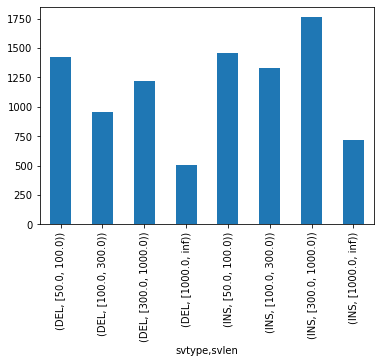

In [55]:

import matplotlib.pyplot as plt 
groups.size().plot.bar()

svlen   [50.0, 100.0)  [100.0, 300.0)  [300.0, 1000.0)  [1000.0, inf)
svtype                                                               
DEL              1421             953             1219            508
INS              1456            1327             1763            714


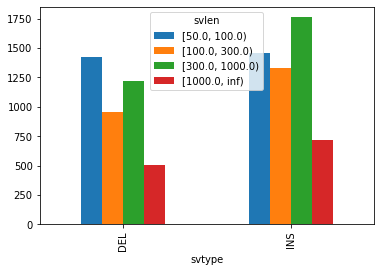

In [56]:
print (groups.size().unstack(fill_value=0))
groups.size().unstack(fill_value=0).plot.bar()

In [57]:
# process the hits in my_top
pd.set_option('display.max_columns', None)
display(my_top)

def groupby_svtype_len(df, bins = [50, 100, 300, 1000, np.Inf]):
    df_uniq = df.drop_duplicates(['name'])   
    print("Unique rows: ", len(df_uniq))
    groups = df_uniq.groupby(['svtype', pd.cut(df_uniq.svlen, bins, right=False)])
    return groups.size()

def summary_sv_callers(df, callers=["svaba", "breakdancer", "manta"], min_ovp_pct=0.7):
    print("Total row count: ", len(df))
    # filter out those did not pass
    df_flt = df.query(f'(svtype!="INS"  & OLscore >= {min_ovp_pct}) | (svtype=="INS" & OLscore >0)' )
    print("Total row count after filtering: ", len(df_flt))

    rv = dict()
    print("Processing all:")
    rv["all"] = groupby_svtype_len(df_flt)
    for sv in callers:
        print("Processing %s:"%(sv))
        rv[sv] = groupby_svtype_len(df_flt.query(f'{sv}=="orig"'))

    return rv

sv_results = summary_sv_callers(my_top)

,chrom,start,end,name,svtype,svlen,chrom2,start2,end2,name2,svaba,breakdancer,manta,caller_count,match_region,OLscore
0,1,9370131,9370186,HG4_Ill_Krunchall_133,DEL,54,1,9369632,9370686,UID_6322,0,0,orig,1,.,0.981818
1,1,205439854,205440024,HG2_10X_SVrefine210Xhap12_866,DEL,169,1,205439355,205440524,UID_9990,0,0,orig,1,.,0.994118
2,1,93810433,93810434,HG2_Ill_GATKHCSBGrefine_389,INS,114,1,93809434,93811435,UID_8139,0,0,orig,1,.,0.000000
3,1,93810433,93810434,HG2_Ill_GATKHCSBGrefine_389,INS,114,1,93809886,93810926,UID_8140,orig,0,0,1,.,0.530000
4,1,218785912,218786233,HG2_10X_allpass_181,DEL,320,1,218785413,218786733,UID_10149,1,0,orig,2,1:218785913-218786234,0.996885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10250,22,40403323,40403324,HG3_PB_pbsv_19264,INS,584,22,40402836,40404047,UID_69153,orig,0,0,1,.,0.870000
10251,22,18977574,18977640,HG2_Ill_scalpel_17775,DEL,65,22,18977075,18978140,UID_68657,0,0,orig,1,.,0.984848
10252,22,19947321,19947389,HG3_Ill_manta_4152,DEL,67,22,19946822,19947889,UID_68670,0,0,orig,1,.,0.985294
10253,22,17863743,17863744,HG2_Ill_150bpfermikitraw_23626,INS,55,22,17862744,17864745,UID_68565,0,0,orig,1,.,0.000000


Total row count:  10255
Total row count after filtering:  6864
Processing all:
Unique rows:  3885
Processing svaba:
Unique rows:  1390
Processing breakdancer:
Unique rows:  1392
Processing manta:
Unique rows:  3264


In [58]:
giab_df.shape

(9361, 6)

In [59]:
sv_results["GIAB Truth"] = groupby_svtype_len(giab_df, bins = [50, 100, 300, 1000, np.Inf])
dat = pd.concat(sv_results, names=["Caller"]).reset_index(name="Size")
dat.head()


Unique rows:  9361


,Caller,svtype,svlen,Size
0,all,DEL,"[50.0, 100.0)",966
1,all,DEL,"[100.0, 300.0)",596
2,all,DEL,"[300.0, 1000.0)",1094
3,all,DEL,"[1000.0, inf)",474
4,all,INS,"[50.0, 100.0)",192


In [60]:
type(dat.svlen[0])

pandas._libs.interval.Interval

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
# g = sns.FacetGrid(dat,  row="svtype",  margin_titles=True)
# g.map(sns.barplot, "Caller", "Size", alpha=.7,  hue="svtype")
# g.add_legend()

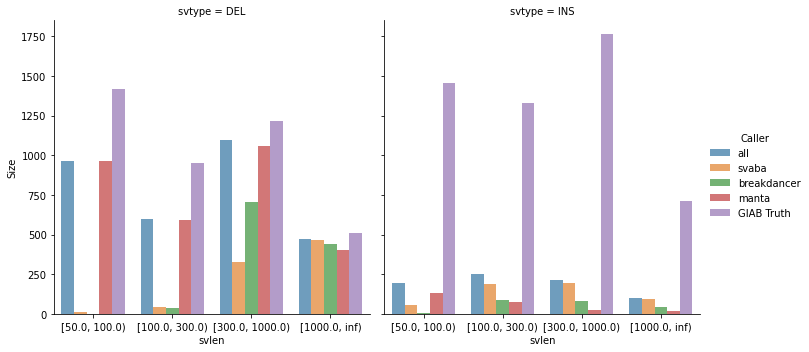

In [96]:
sns.catplot(x="svlen", y="Size", alpha=.7,  hue="Caller", data=dat, kind="bar", col="svtype")

In [97]:
# comb_inc.shape

In [98]:
sv="manta"
my_top.query(f'{sv}=="orig"')

,chrom,start,end,name,svtype,svlen,chrom2,start2,end2,name2,svaba,breakdancer,manta,caller_count,match_region,OLscore
0,1,9370131,9370186,HG4_Ill_Krunchall_133,DEL,54,1,9369632,9370686,UID_6322,0,0,orig,1,.,0.981818
1,1,205439854,205440024,HG2_10X_SVrefine210Xhap12_866,DEL,169,1,205439355,205440524,UID_9990,0,0,orig,1,.,0.994118
2,1,93810433,93810434,HG2_Ill_GATKHCSBGrefine_389,INS,114,1,93809434,93811435,UID_8139,0,0,orig,1,.,0.000000
4,1,218785912,218786233,HG2_10X_allpass_181,DEL,320,1,218785413,218786733,UID_10149,1,0,orig,2,1:218785913-218786234,0.996885
6,1,30298151,30298204,HG3_Ill_GATKHCSBGrefine_174,DEL,52,1,30297652,30298704,UID_7139,0,0,orig,1,.,0.981132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10246,22,35645163,35646139,HG4_10X_allpass_3456,DEL,975,22,35644664,35646639,UID_69063,1,1,orig,3,22:35645164-35646140,0.998975
10251,22,18977574,18977640,HG2_Ill_scalpel_17775,DEL,65,22,18977075,18978140,UID_68657,0,0,orig,1,.,0.984848
10252,22,19947321,19947389,HG3_Ill_manta_4152,DEL,67,22,19946822,19947889,UID_68670,0,0,orig,1,.,0.985294
10253,22,17863743,17863744,HG2_Ill_150bpfermikitraw_23626,INS,55,22,17862744,17864745,UID_68565,0,0,orig,1,.,0.000000


In [99]:
mocca_df = comb_inc.to_dataframe()
mocca_df.columns = ["chrom", "start", "end", "name", "svaba", "breakdancer", "manta", "caller_count", "match_region"]
mocca_df.head

<bound method NDFrame.head of        chrom     start       end       name svaba breakdancer manta  \
0          1    931732    932070   UID_5403  orig           0     0   
1          1   1285581   1286795   UID_5409     0        orig     0   
2          1   1500563   1501564   UID_5416     0           0  orig   
3          1   1501010   1501107   UID_5417     0           0  orig   
4          1   1530500   1530850   UID_5418     0           0  orig   
...      ...       ...       ...        ...   ...         ...   ...   
27770     22  50919110  50919122  UID_69472     0        orig     0   
27771     22  51028795  51028820  UID_69475     0        orig     0   
27772     22  51050837  51050887  UID_69476     0        orig     0   
27773     22  51055309  51055424  UID_69477     0        orig     0   
27774     22  51055318  51055603  UID_69478  orig           0     0   

       caller_count match_region  
0                 1            .  
1                 1            .  
2           

In [100]:
stat_df = pd.DataFrame()
stat_df['tp']=pd.concat(sv_results, names=["Caller"]).groupby('Caller').sum()
stat_df['giab']=9631
stat_df.drop('GIAB Truth', inplace=True)



for s in stat_df.index.values.tolist():
    print(s)
    dd = mocca_df
    if s != 'all':
        dd = mocca_df.query(f'{s} == "orig"')
    
    stat_df.loc[s,'predict'] = len(dd)


my_index=pd.MultiIndex.from_product([["tp", "tp2"], ['0.5', '0.7', '0.9']])
print(my_index)

df2 = pd.DataFrame(index=stat_df.index, columns=my_index)

for x in [0.5, 0.7, 0.9]:
    flt = my_top.query(f'(svtype!="INS"  & OLscore >= {x}) | (svtype=="INS" & OLscore >0)' )

    for s in stat_df.index.values.tolist():
        dd = flt
        if s != 'all':
            dd = flt.query(f'{s} == "orig"')

        df2.loc[s,('tp',str(x))] = len(dd.drop_duplicates(['name']))
        df2.loc[s,('tp2',str(x))] = len(dd.drop_duplicates(['name2']))

all
svaba
breakdancer
manta
MultiIndex([( 'tp', '0.5'),
            ( 'tp', '0.7'),
            ( 'tp', '0.9'),
            ('tp2', '0.5'),
            ('tp2', '0.7'),
            ('tp2', '0.9')],
           )


In [101]:

x=pd.concat([stat_df, df2], axis=1, levels=0).reset_index().set_index(["Caller", "tp", "giab", "predict"]).sort_index(axis=1)
x.columns = pd.MultiIndex.from_tuples(x.columns, names=["tp", "cutoff"])

x.to_excel("performance.xlsx")

In [102]:
z

,truth,predict,"(tp, 0.5)","(tp, 0.7)","(tp, 0.9)","(tp2, 0.5)","(tp2, 0.7)","(tp2, 0.9)"
Caller,,,,,,,,
svaba,371,136,107,107,107,128,128,127
breakdancer,371,32227,56,49,40,67,60,45
delly,371,279,91,91,90,125,125,123
manta,371,123,114,114,114,120,119,119
all,371,32765,120,120,119,440,432,414


In [103]:

z = pd.concat([stat_df, df2], axis=1, levels=0)
z2=z.drop(['tp'], axis=1).reset_index().melt(id_vars=["Caller", "giab","predict"])
z2[['type','p']] = pd.DataFrame(z2['variable'].tolist())
z2 = z2.assign(Sn=z2['value']/z2['giab'], Sp=z2['value']/z2['predict'])
z2

,Caller,giab,predict,variable,value,type,p,Sn,Sp
0,all,9631,27775.0,"(tp, 0.5)",3956,tp,0.5,0.410757,0.14243
1,svaba,9631,4168.0,"(tp, 0.5)",1406,tp,0.5,0.145987,0.337332
2,breakdancer,9631,18254.0,"(tp, 0.5)",1609,tp,0.5,0.167065,0.0881451
3,manta,9631,5353.0,"(tp, 0.5)",3312,tp,0.5,0.34389,0.618718
4,all,9631,27775.0,"(tp, 0.7)",3885,tp,0.7,0.403385,0.139874
5,svaba,9631,4168.0,"(tp, 0.7)",1390,tp,0.7,0.144326,0.333493
6,breakdancer,9631,18254.0,"(tp, 0.7)",1392,tp,0.7,0.144533,0.0762573
7,manta,9631,5353.0,"(tp, 0.7)",3264,tp,0.7,0.338906,0.609752
8,all,9631,27775.0,"(tp, 0.9)",3751,tp,0.9,0.389471,0.13505
9,svaba,9631,4168.0,"(tp, 0.9)",1330,tp,0.9,0.138096,0.319098


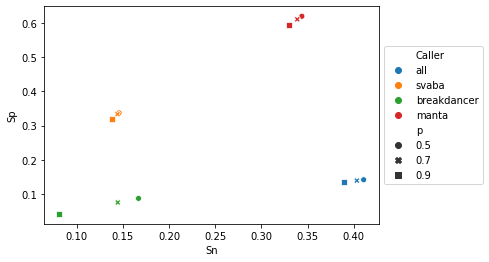

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
g=sns.scatterplot(x="Sn", y="Sp", data=z2.query('type == "tp"'),hue="Caller", style="p")
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
plt.show()

In [105]:
pd.merge(stat_df, df2,left_index=True, right_index=True)

/home/zhuw10/.local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,tp,giab,predict,"(tp, 0.5)","(tp, 0.7)","(tp, 0.9)","(tp2, 0.5)","(tp2, 0.7)","(tp2, 0.9)"
Caller,,,,,,,,,
all,3885,9631,27775.0,3956,3885,3751,7398,6864,5821
svaba,1390,9631,4168.0,1406,1390,1330,1760,1740,1649
breakdancer,1392,9631,18254.0,1609,1392,783,2313,1848,983
manta,3264,9631,5353.0,3312,3264,3178,3325,3276,3189


In [106]:
giab_df

,chrom,start,end,name,svtype,svlen
0,1,9370131,9370186,HG4_Ill_Krunchall_133,DEL,54
1,1,102123409,102123491,HG2_Ill_SVrefine2DISCOVARplusDovetail_553,DEL,81
2,1,205439854,205440024,HG2_10X_SVrefine210Xhap12_866,DEL,169
3,1,9342496,9342497,HG2_PB_SVrefine2PB10Xhap12_167,INS,268
4,1,93810433,93810434,HG2_Ill_GATKHCSBGrefine_389,INS,114
...,...,...,...,...,...,...
9356,22,17863743,17863744,HG2_Ill_150bpfermikitraw_23626,INS,55
9357,22,17889021,17889022,HG2_PB_SVrefine2PBcRplusDovetail_6957,INS,848
9358,22,19210894,19210895,HG3_PB_SVrefine2Falcon1Dovetail_12097,INS,6044
9359,22,45002747,45002748,HG4_Ill_GATKHC_30540,INS,100


In [107]:
comb_df.head()

,#CHROM,start,end,svaba,breakdancer,manta,caller_count,match_region,RepeatMasker,SegDups,Telo_Centro,1KG_sv_type,1KG_pheno,1KG_clinical_assertion,ClinGen_sv_type,ClinGen_pheno,ClinGen_clinical_assertion,ClinVar_sv_type,ClinVar_pheno,ClinVar_clinical_assertion,DGV_sv_type,DGV_pheno,DGV_clinical_assertion,RefSeq_transcripts,RefSeq_genes,Original_caller_output
0,GL000208.1,0,2713,orig,0,0,1,.,0,0,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,GL000208.1__0__87061841:1__N__]GL000208.1:2713...
1,GL000225.1,0,122878,orig,0,0,1,.,0,0,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,GL000225.1__0__755156259:1__N__]GL000225.1:122...
2,GL000225.1,0,99323,orig,0,0,1,.,0,0,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,GL000225.1__0__40745826:1__N__]GL000225.1:9932...
3,GL000208.1,1,2295,orig,0,0,1,.,0,0,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,GL000208.1__1__352684968:1__G__]GL000208.1:229...
4,MT,1,16569,orig,0,0,1,.,0,0,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,MT__1__875457617:1__G__]MT:16569]G__75__LOWAS_...


# Check somatic mutation using synthetic dataset

In [108]:
# Load IS1 truth file
_is1 = pd.read_csv("synthetic/is1_truth.bed", header=None, sep="\t")
_is1.columns = ["chrom", "start", "stop", "name", "x0","x1", "x2", "svtype", 'y1', "y2", "y3", "y4"]
is1_base  = _is1[ ["chrom", "start", "stop", "svtype"] ].assign(svlen=_is1.stop-_is1.start)
is1_base
is1_base_bt = df_to_bedtool(is1_base, onebased=False, first_N=5)
print(is1_base_bt[0])

1	25204182	25210854	UID_0	DUP	6672



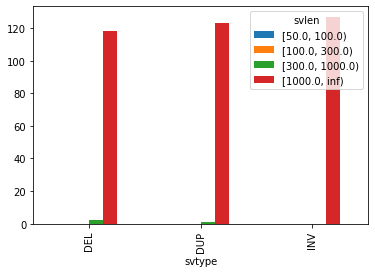

In [109]:
is1_groups = is1_base.groupby(['svtype', pd.cut(is1_base.svlen, bins, right=False)])
is1_groups.size().unstack(fill_value=0).plot.bar()

In [110]:
is1_mocca = pd.read_csv("../test/synthetic_rep1/output/compare_and_annotate/intrachromosomal_SVs_IS1", header=0, sep="\t")
chrs = list(map(str, range(1,23)))+['X','Y']
is1_mocca = is1_mocca[is1_mocca['#CHROM'].isin(chrs)]

# add Name and convert to bedtool
is1_mocca_bt = df_to_bedtool(is1_mocca, onebased=False, first_N=9)
print(is1_mocca_bt[0])


/home/zhuw10/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


X	85778	86112	UID_1	0	0	orig	0	1	.



In [117]:
def compare_base_comp(base, comp, base_ind=None, comp_ind=None, names=None, pad=500, g="b37.genome",  base_id_name="name", comp_id_name="name2"):
    if base_ind is None:
        base_ind = index_interval(base)

    if comp_ind is None:
        comp_ind = index_interval(comp)

    comp_padded = comp.slop(b=pad, g=g)
    overlaps = base.intersect(comp_padded, wa=True, wb=True)

    print(overlaps)
    df = overlaps.to_dataframe(names=names)
    
    # df['OLscore'] = df.apply(lambda x: calc_score(base, x.get(base_id_name), comp, x.get(comp_id_name)), axis=1)
    df['OLscore'] = df.apply(lambda x: calc_score2(base_ind.get(x.get(base_id_name)), comp_ind.get( x.get(comp_id_name))), axis=1)
    #print(df.head())
    return(df)

is1_compare = compare_base_comp(is1_base_bt, is1_mocca_bt, names=["chrom", "start", "end", "name", "svtype", "svlen", "chrom2", "start2", "end2", "name2", "svaba", "breakdancer", "delly", "manta", "caller_count", "match_region"])


1	25204182	25210854	UID_0	DUP	6672	1	25203675	25211319	UID_5886	1	0	orig	1	3	1:25204175-25210854,1:25204175-25210852
1	25204182	25210854	UID_0	DUP	6672	1	25203681	25211352	UID_5887	1	0	1	orig	3	1:25204181-25210854,1:25204175-25210852
1	25204182	25210854	UID_0	DUP	6672	1	25203682	25211354	UID_5888	orig	0	1	1	3	1:25204175-25210854,1:25204181-25210854
1	25204182	25210854	UID_0	DUP	6672	1	17125155	234919716	UID_5604	0	orig	0	0	1	.
1	32176186	32193834	UID_1	INV	17648	1	32175307	32178273	UID_6151	0	orig	0	0	1	.
1	32176186	32193834	UID_1	INV	17648	1	32175687	32194334	UID_6152	2	1	2	orig	4	1:32176187-32193834,1:32176187-32193835,1:32176187-32194418
1	32176186	32193834	UID_1	INV	17648	1	32175687	32194334	UID_6153	orig	1	2	1	4	1:32176187-32194418,1:32176187-32193834
1	32176186	32193834	UID_1	INV	17648	1	32175688	32194335	UID_6154	orig	1	2	1	4	1:32176188-32194418,1:32176188-32193835,1:32176187-32193835
1	32176186	32193834	UID_1	INV	17648	1	32175692	32194330	UID_6155	2	1	orig	1	4	1:32176187-321938

In [112]:
is1_compare.head()

,chrom,start,end,name,svtype,svlen,chrom2,start2,end2,name2,svaba,breakdancer,delly,manta,caller_count,match_region,OLscore
0,1,25204182,25210854,UID_0,DUP,6672,1,25203675,25211319,UID_5886,1,0,orig,1,3,"1:25204175-25210854,1:25204175-25210852",0.994754
1,1,25204182,25210854,UID_0,DUP,6672,1,25203681,25211352,UID_5887,1,0,1,orig,3,"1:25204181-25210854,1:25204175-25210852",0.999700
2,1,25204182,25210854,UID_0,DUP,6672,1,25203682,25211354,UID_5888,orig,0,1,1,3,"1:25204175-25210854,1:25204181-25210854",1.000000
3,1,25204182,25210854,UID_0,DUP,6672,1,17125155,234919716,UID_5604,0,orig,0,0,1,.,0.000031
4,1,32176186,32193834,UID_1,INV,17648,1,32175307,32178273,UID_6151,0,orig,0,0,1,.,0.089925


In [113]:
is1_summary = summary_sv_callers(is1_compare)
is1_summary

Total row count:  592
Total row count after filtering:  432
Processing all:
Unique rows:  120
Processing svaba:
Unique rows:  107
Processing breakdancer:
Unique rows:  49
Processing manta:
Unique rows:  114


{'all': svtype  svlen          
 DEL     [50.0, 100.0)       0
         [100.0, 300.0)      0
         [300.0, 1000.0)     0
         [1000.0, inf)      37
 DUP     [50.0, 100.0)       0
         [100.0, 300.0)      0
         [300.0, 1000.0)     0
         [1000.0, inf)      39
 INV     [50.0, 100.0)       0
         [100.0, 300.0)      0
         [300.0, 1000.0)     0
         [1000.0, inf)      44
 dtype: int64,
 'svaba': svtype  svlen          
 DEL     [50.0, 100.0)       0
         [100.0, 300.0)      0
         [300.0, 1000.0)     0
         [1000.0, inf)      34
 DUP     [50.0, 100.0)       0
         [100.0, 300.0)      0
         [300.0, 1000.0)     0
         [1000.0, inf)      37
 INV     [50.0, 100.0)       0
         [100.0, 300.0)      0
         [300.0, 1000.0)     0
         [1000.0, inf)      36
 dtype: int64,
 'breakdancer': svtype  svlen          
 DEL     [50.0, 100.0)       0
         [100.0, 300.0)      0
         [300.0, 1000.0)     0
         [1000.0, inf)     

In [114]:
# compare it 
def summary_compare(my_top, N, callers=['svaba', 'breakdancer', 'delly', 'manta', 'all'], cutoff_p=[0.5,0.7, 0.9]):

    my_index=pd.MultiIndex.from_product([["tp", "tp2"], map(str, cutoff_p)])
    
    df2 = pd.DataFrame(index=callers, columns=my_index)

    for x in cutoff_p:
        flt = my_top.query(f'(svtype!="INS"  & OLscore >= {x}) | (svtype=="INS" & OLscore >0)' )

        for s in callers:
            dd = flt
            if s != 'all':
                dd = flt.query(f'{s} == "orig"')

            df2.loc[s,('tp',str(x))] = len(dd.drop_duplicates(['name']))
            df2.loc[s,('tp2',str(x))] = len(dd.drop_duplicates(['name2']))

    return df2

is1_summary = summary_compare(is1_compare, 371)

# is1_summary['truth']=371

rv=pd.DataFrame(index=is1_summary.index, columns=['truth', 'predict'])
rv['truth']=371
for s in ['svaba', 'breakdancer', 'delly', 'manta', 'all']:
    print(s)
    dd = is1_mocca
    if s != 'all':
        dd = dd.query(f'{s} == "orig"')
    
    rv.loc[s, 'predict']=len(dd)

z = pd.concat([rv, is1_summary], axis=1)
z.index.name="Caller"
z

svaba
breakdancer
delly
manta
all


,truth,predict,"(tp, 0.5)","(tp, 0.7)","(tp, 0.9)","(tp2, 0.5)","(tp2, 0.7)","(tp2, 0.9)"
Caller,,,,,,,,
svaba,371,136,107,107,107,128,128,127
breakdancer,371,32227,56,49,40,67,60,45
delly,371,279,91,91,90,125,125,123
manta,371,123,114,114,114,120,119,119
all,371,32765,120,120,119,440,432,414


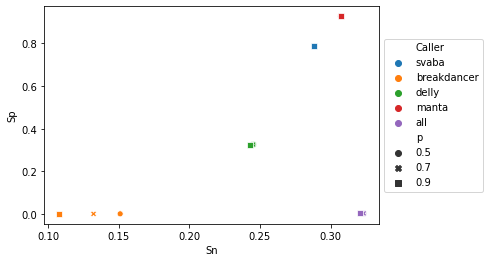

In [115]:
z2=z.reset_index().melt(id_vars=["Caller", "truth","predict"])

z2[['type','p']] = pd.DataFrame(z2['variable'].tolist())
z2 = z2.assign(Sn=z2['value']/z2['truth'], Sp=z2['value']/z2['predict'])
z2

g=sns.scatterplot(x="Sn", y="Sp", data=z2.query('type == "tp"'),hue="Caller", style="p")
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
plt.show()

In [116]:
is1_compare


,chrom,start,end,name,svtype,svlen,chrom2,start2,end2,name2,svaba,breakdancer,delly,manta,caller_count,match_region,OLscore
0,1,25204182,25210854,UID_0,DUP,6672,1,25203675,25211319,UID_5886,1,0,orig,1,3,"1:25204175-25210854,1:25204175-25210852",0.994754
1,1,25204182,25210854,UID_0,DUP,6672,1,25203681,25211352,UID_5887,1,0,1,orig,3,"1:25204181-25210854,1:25204175-25210852",0.999700
2,1,25204182,25210854,UID_0,DUP,6672,1,25203682,25211354,UID_5888,orig,0,1,1,3,"1:25204175-25210854,1:25204181-25210854",1.000000
3,1,25204182,25210854,UID_0,DUP,6672,1,17125155,234919716,UID_5604,0,orig,0,0,1,.,0.000031
4,1,32176186,32193834,UID_1,INV,17648,1,32175307,32178273,UID_6151,0,orig,0,0,1,.,0.089925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,X,119595996,119598596,UID_369,DEL,2600,X,119595493,119599139,UID_3924,1,orig,1,1,4,"X:119595993-119598639,X:119595950-119598639,X:...",0.982615
588,X,119595996,119598596,UID_369,DEL,2600,X,119595497,119599097,UID_3925,orig,1,1,1,4,"X:119595993-119598639,X:119595950-119598639,X:...",0.999615
589,X,139585001,139588560,UID_370,DUP,3559,X,139584502,139589060,UID_4608,1,0,1,orig,3,X:139585002-139588560,0.999719
590,X,139585001,139588560,UID_370,DUP,3559,X,139584503,139589060,UID_4609,orig,0,1,1,3,"X:139585003-139588560,X:139585002-139588560",0.999438
